# VELOCITY MODEL CREATION 
To the specifications defined by Bing

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import os
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt

import pyfrac
from pyfrac.utils.sofiutils import *
from pyfrac.utils.modellingutils import *
from pyfrac.hydrafrac.acquisition import recgeom
from pyfrac.visualisation.plotting_support import explode_volume

In [2]:
model_outpath = '/home/birniece/Documents/data/ANPERC_Lab/STYLOLITES/StyloliteModels'
figpath = './Figures/StyloliteModels/'

------------------

# Rock Properties - subsurface models

In [3]:
abs_bounds = 30 # boundary points

dx = dy = dz = 0.001  # 1mm
dimlims = 0.4 + 2*(abs_bounds*dx) # 40cm cubed
nx = ny = nz = int(dimlims/dx) 
print(nx)
# dimlims = nx*dx

460


In [4]:
# Subsurface properties
vp = 5260  # m/s
vs = vp/1.61
rho =  1000 * (0.31*vp**0.25)

vs_o = 3260  # m/s
rho_o = 2590;  # kg/m3

print(vs, vs_o)
print(rho, rho_o)

3267.0807453416146 3260
2640.025549441101 2590


In [5]:
perc_changes = [0.7, 0.8, 0.9]
print(perc_changes)

[0.7, 0.8, 0.9]


--------------

In [6]:
def plot_XYslice(vp_mod_sty, expname, abs_bounds):
    fig,ax = plt.subplots(1,1,figsize=[5,5])
    c = ax.imshow(vp_mod_sty[abs_bounds:-abs_bounds,abs_bounds:-abs_bounds,0].T, 
                  aspect='auto', cmap='copper', vmax=vp, vmin=vp*0.7,
                  extent=[0,40,40,0],
                 )
    ax.set_title(expname); ax.set_ylabel('y [cm]'); ax.set_xlabel('x [cm]');
    return fig

# HOMOGENEOUS MODEL

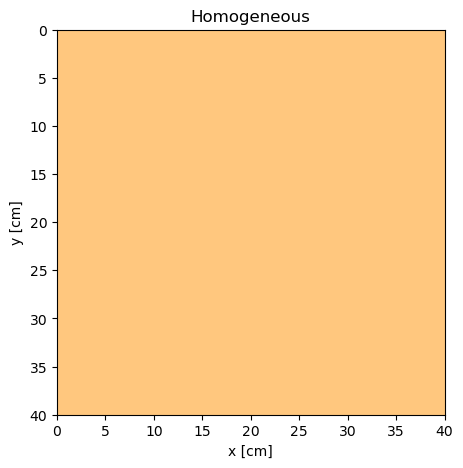

In [7]:
subsurface_properties = [vp, vs, rho]
vp_mod, vs_mod, rho_mod = make_homo_model(dimlims,
                                            dx,
                                            subsurface_properties,
                                            pad=False,
                                            npad=0,
                                            freesurface=False
                                            )
# # Write as binary
expname = 'Homogeneous'
vp_mod.astype(np.float32).tofile(os.path.join(model_outpath,'%s.vp'%expname))#,format='<f')
vs_mod.astype(np.float32).tofile(os.path.join(model_outpath,'%s.vs'%expname))  #,format='<f')
rho_mod.astype(np.float32).tofile(os.path.join(model_outpath,'%s.rho'%expname))  #,format='<f')

fig = plot_XYslice(vp_mod, expname, abs_bounds)
fig.savefig(os.path.join(figpath,expname+'.png'), format='png')

In [21]:
print(vp_mod.shape)

(460, 460, 460)


----------------

# SINUSOIDAL STYLOLITE

In [8]:
def make_sine_stylolites(sinewave,
                         vp_mod,
                         vs_mod,
                         rho_mod,
                         percchange, 
                         yo = [100, 175,350]):

    vp = np.mean(vp_mod)
    
    vp_mod_sty = vp_mod.copy()
    vs_mod_sty = vs_mod.copy()
    rho_mod_sty = rho_mod.copy()
    
    for ix in range(nx):
        # THREE STYLOLITES
        vp_mod_sty[ix,yo[0]+np.round(sinewave[ix]).astype('int'),:] = vp*percchange
        vs_mod_sty[ix,yo[0]+np.round(sinewave[ix]).astype('int'),:] = (vp*percchange)/1.61
        rho_mod_sty[ix,yo[0]+np.round(sinewave[ix]).astype('int'),:] = 1000 * (0.31*(vp*percchange)**0.25)
        
        vp_mod_sty[ix,yo[1]+np.round(sinewave[ix]).astype('int'),:] = vp*percchange
        vs_mod_sty[ix,yo[1]+np.round(sinewave[ix]).astype('int'),:] = (vp*percchange)/1.61
        rho_mod_sty[ix,yo[1]+np.round(sinewave[ix]).astype('int'),:] = 1000 * (0.31*(vp*percchange)**0.25)
        
        vp_mod_sty[ix,yo[2]+np.round(sinewave[ix]).astype('int'),:] = vp*percchange
        vs_mod_sty[ix,yo[2]+np.round(sinewave[ix]).astype('int'),:] = (vp*percchange)/1.61
        rho_mod_sty[ix,yo[2]+np.round(sinewave[ix]).astype('int'),:] = 1000 * (0.31*(vp*percchange)**0.25)
    return vp_mod_sty,vs_mod_sty,rho_mod_sty

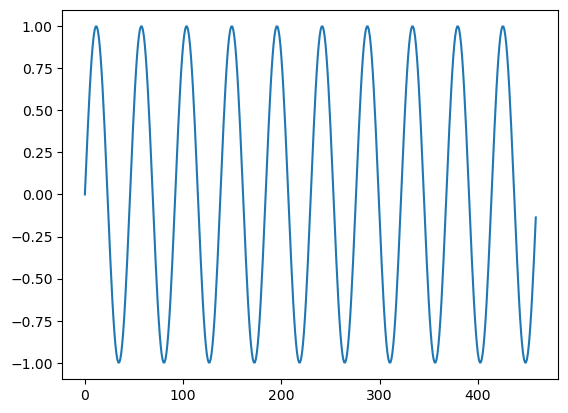

In [9]:
cycles = 10 # how many sine cycles
resolution = nx # how many datapoints to generate

length = np.pi * 2 * cycles
unitwave = np.sin(np.arange(0, length, length / resolution)) 
plt.plot(unitwave)

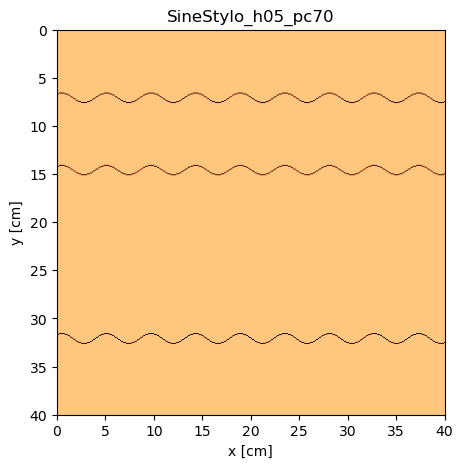

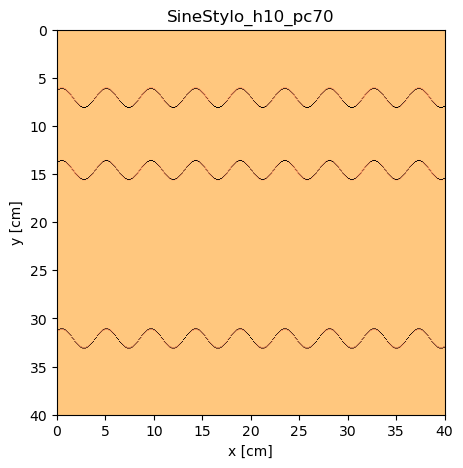

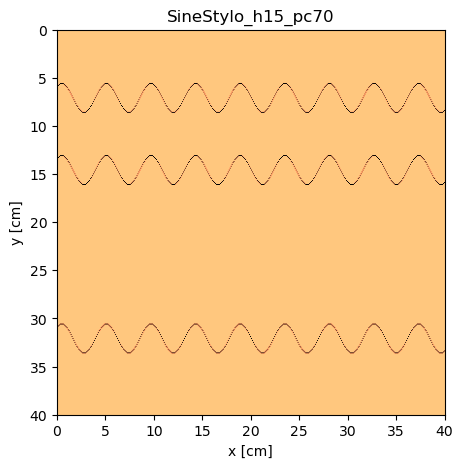

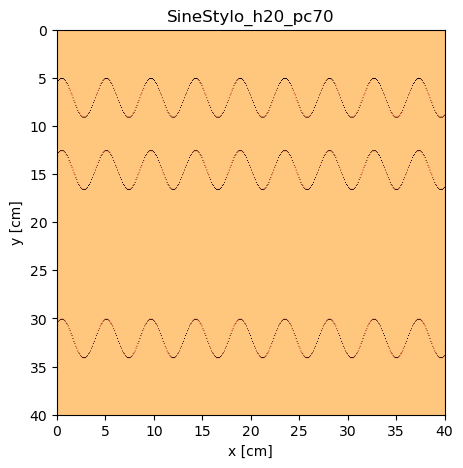

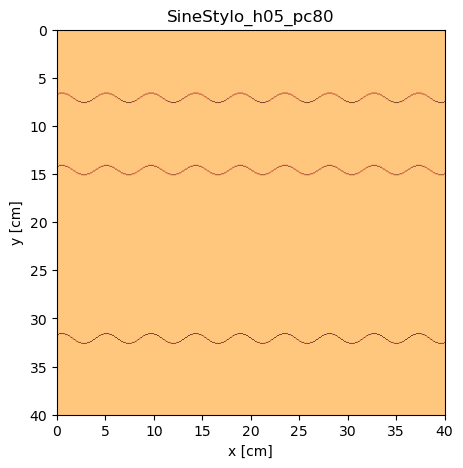

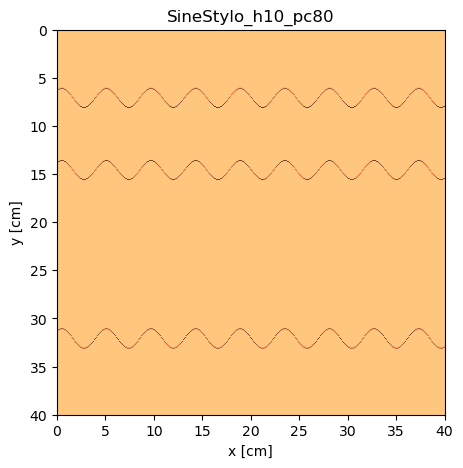

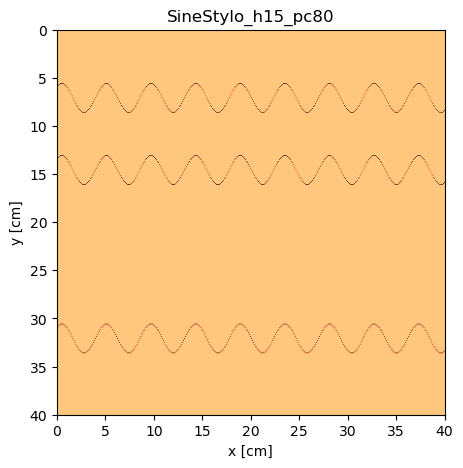

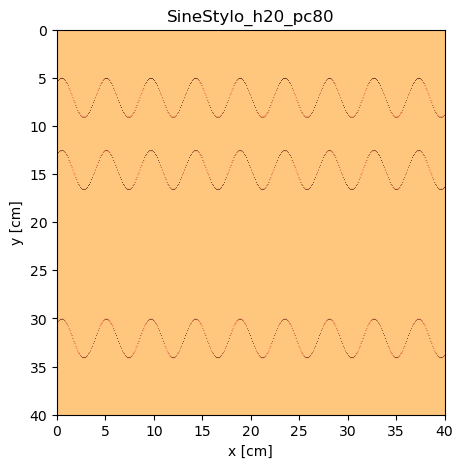

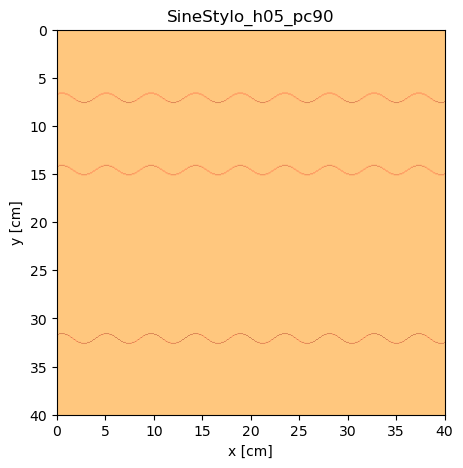

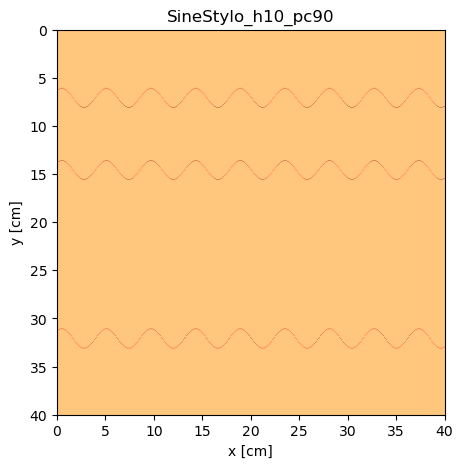

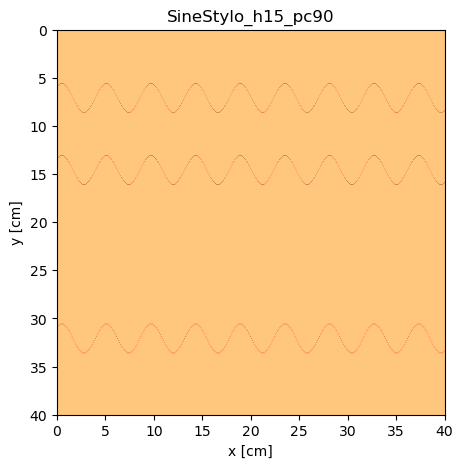

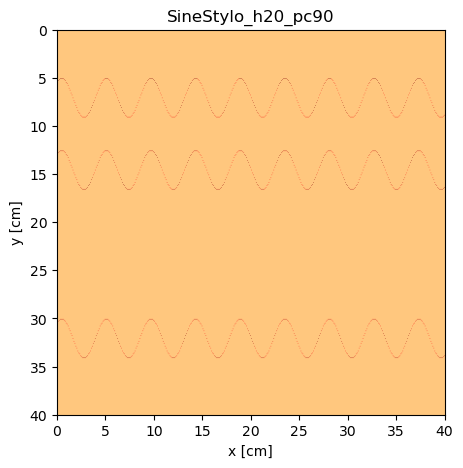

In [10]:
heights = np.arange(5,21,5)
yo = [100, 175,350]

for pc in perc_changes:
    for height in heights:
        sinewave = unitwave * height
        vp_mod_sty,vs_mod_sty,rho_mod_sty = make_sine_stylolites(sinewave,
                                                                 vp_mod,
                                                                 vs_mod,
                                                                 rho_mod,
                                                                 percchange=pc, 
                                                                 yo = [100, 175,350])
        
        
        # # Write as binary
        expname = 'SineStylo_h%.2i_pc%.2i'%(height,pc*100)
        vp_mod_sty.astype(np.float32).tofile(os.path.join(model_outpath,'%s.vp'%expname))#,format='<f')
        vs_mod_sty.astype(np.float32).tofile(os.path.join(model_outpath,'%s.vs'%expname))  #,format='<f')
        rho_mod_sty.astype(np.float32).tofile(os.path.join(model_outpath,'%s.rho'%expname))  #,format='<f')
        
        fig = plot_XYslice(vp_mod_sty, expname, abs_bounds)
        fig.savefig(os.path.join(figpath,expname+'.png'), format='png')
        
    # fig,ax = plt.subplots(1,1,figsize=[5,5])
    # c = ax.imshow(vp_mod_sty[10,abs_bounds:-abs_bounds,abs_bounds:-abs_bounds], cmap='copper')
    # fig,ax = plt.subplots(1,1,figsize=[5,5])
    # c = ax.imshow(vp_mod_sty[abs_bounds:-abs_bounds,yo[0],abs_bounds:-abs_bounds], cmap='copper')

---------------------

# Varying Thickness

In [11]:
def make_thick_stylolites(thickness,
                          vp_mod,
                          vs_mod,
                          rho_mod,
                          percchange, 
                          yo = [100, 175,350]):

    vp = np.mean(vp_mod)
    
    vp_mod_sty = vp_mod.copy()
    vs_mod_sty = vs_mod.copy()
    rho_mod_sty = rho_mod.copy()
    
    for ix in range(nx):
        # THREE STYLOLITES
        vp_mod_sty[ix,yo[0]:yo[0]+thickness,:] = vp*percchange
        vs_mod_sty[ix,yo[0]:yo[0]+thickness,:] = (vp*percchange)/1.61
        rho_mod_sty[ix,yo[0]:yo[0]+thickness,:] = 1000 * (0.31*(vp*percchange)**0.25)
        
        vp_mod_sty[ix,yo[1]:yo[1]+thickness,:] = vp*percchange
        vs_mod_sty[ix,yo[1]:yo[1]+thickness,:] = (vp*percchange)/1.61
        rho_mod_sty[ix,yo[1]:yo[1]+thickness,:] = 1000 * (0.31*(vp*percchange)**0.25)
        
        vp_mod_sty[ix,yo[2]:yo[2]+thickness,:] = vp*percchange
        vs_mod_sty[ix,yo[2]:yo[2]+thickness,:] = (vp*percchange)/1.61
        rho_mod_sty[ix,yo[2]:yo[2]+thickness,:] = 1000 * (0.31*(vp*percchange)**0.25)
        
    return vp_mod_sty,vs_mod_sty,rho_mod_sty

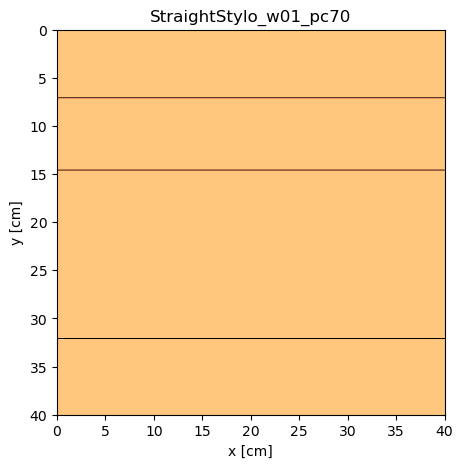

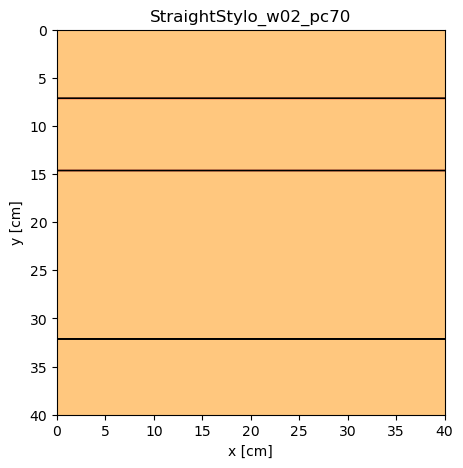

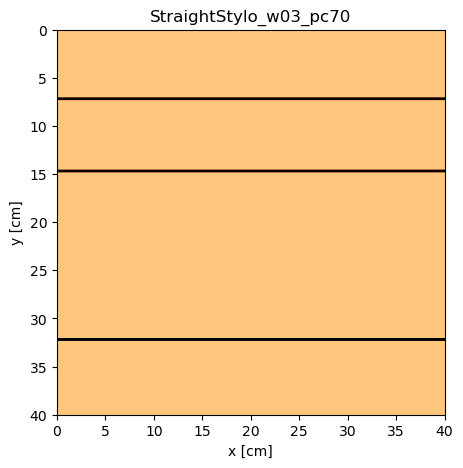

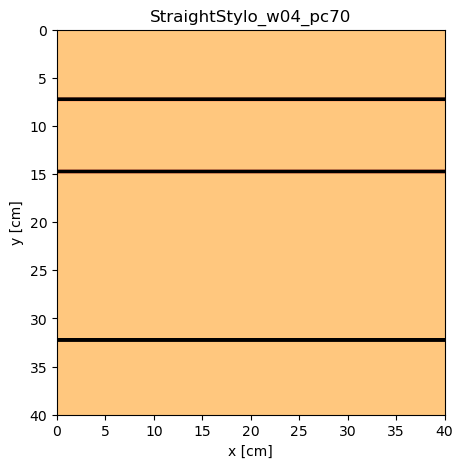

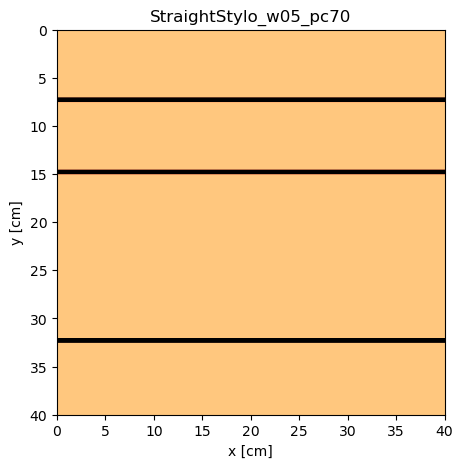

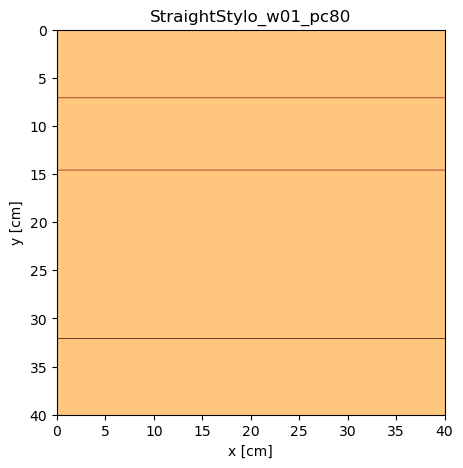

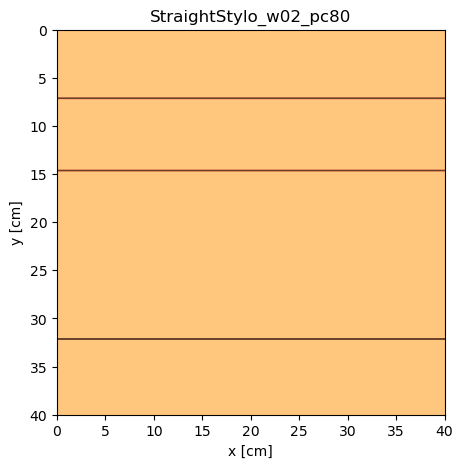

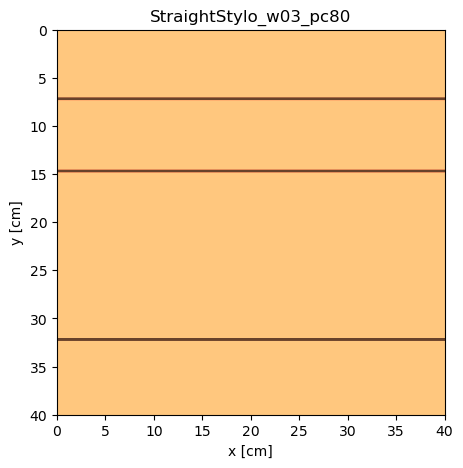

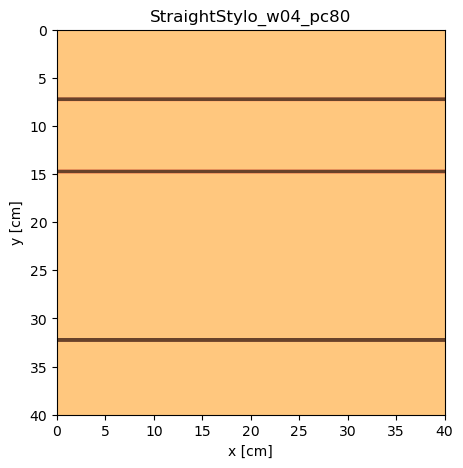

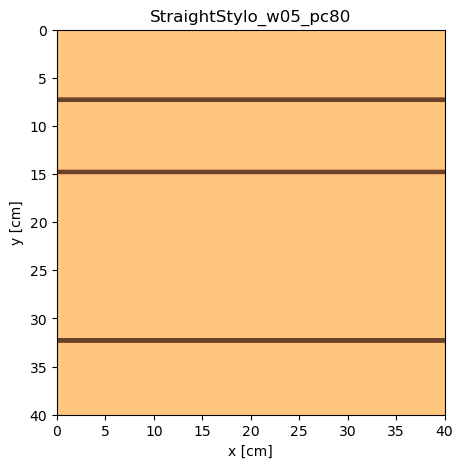

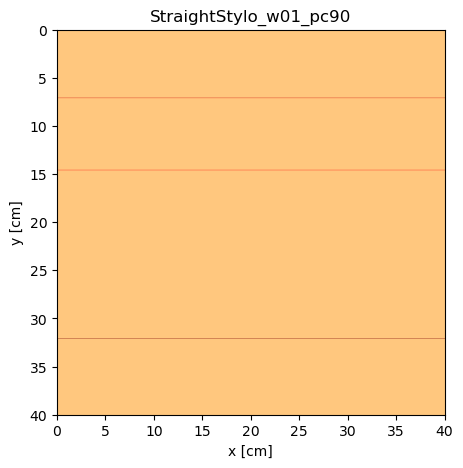

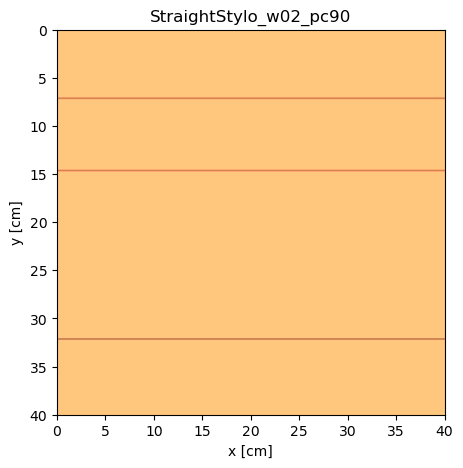

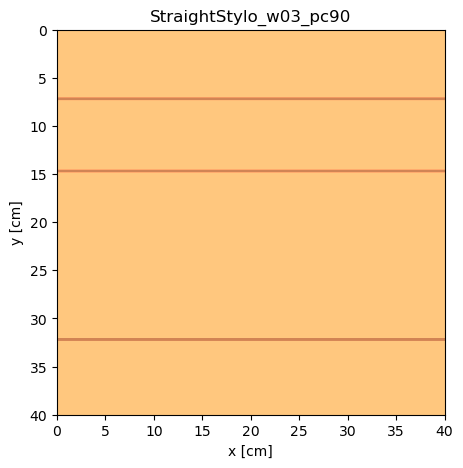

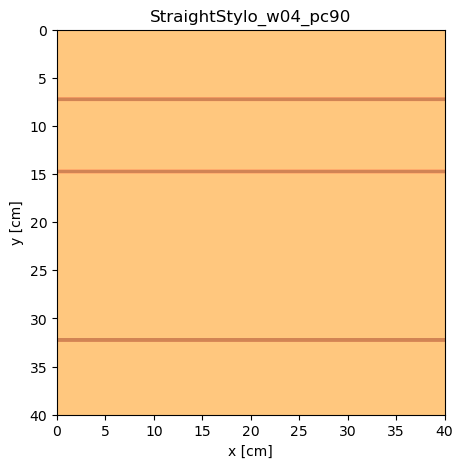

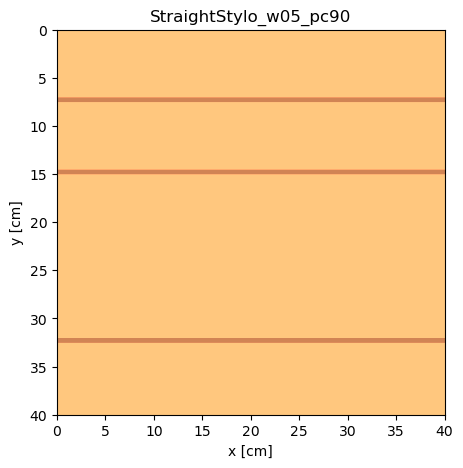

In [12]:
yo = [100, 175,350]
thicknesses = np.arange(1,6)

for pc in perc_changes:
    for thickness in thicknesses:
        vp_mod_sty,vs_mod_sty,rho_mod_sty = make_thick_stylolites(thickness,
                                                          vp_mod,
                                                          vs_mod,
                                                          rho_mod,
                                                          pc, 
                                                          yo = [100, 175,350])
        
        
        # Write as binary
        expname = 'StraightStylo_w%.2i_pc%.2i'%(thickness,pc*100)
        vp_mod_sty.astype(np.float32).tofile(os.path.join(model_outpath,'%s.vp'%expname))#,format='<f')
        vs_mod_sty.astype(np.float32).tofile(os.path.join(model_outpath,'%s.vs'%expname))  #,format='<f')
        rho_mod_sty.astype(np.float32).tofile(os.path.join(model_outpath,'%s.rho'%expname))  #,format='<f')
        
        fig = plot_XYslice(vp_mod_sty, expname, abs_bounds)
        fig.savefig(os.path.join(figpath,expname+'.png'), format='png')


-----------------

# Varied Inclination

In [13]:
def make_angled_stylolites(angle,
                          vp_mod,
                          vs_mod,
                          rho_mod,
                          percchange, 
                          yo = [100, 175,350]):

    vp = np.mean(vp_mod)
    
    vp_mod_sty = vp_mod.copy()
    vs_mod_sty = vs_mod.copy()
    rho_mod_sty = rho_mod.copy()
    
    sl = np.tan(np.radians(angle))
    x = np.arange(nx)
    y = sl*x + 0
    
    for ix in range(nx):
        # THREE STYLOLITES
        if int(yo[0]+y[ix])<ny: 
            vp_mod_sty[ix,int(yo[0]+y[ix]),:] = vp*percchange
            vs_mod_sty[ix,int(yo[0]+y[ix]),:] = (vp*percchange)/1.61
            rho_mod_sty[ix,int(yo[0]+y[ix]),:] = 1000 * (0.31*(vp*percchange)**0.25)
        
        if int(yo[1]+y[ix])<ny:    
            vp_mod_sty[ix,int(yo[1]+y[ix]),:] = vp*percchange
            vs_mod_sty[ix,int(yo[1]+y[ix]),:] = (vp*percchange)/1.61
            rho_mod_sty[ix,int(yo[1]+y[ix]),:] = 1000 * (0.31*(vp*percchange)**0.25)
        
        if int(yo[2]+y[ix])<ny:
            vp_mod_sty[ix,int(yo[2]+y[ix]),:] = vp*percchange
            vs_mod_sty[ix,int(yo[2]+y[ix]),:] = (vp*percchange)/1.61
            rho_mod_sty[ix,int(yo[2]+y[ix]),:] = 1000 * (0.31*(vp*percchange)**0.25)
        
    return vp_mod_sty,vs_mod_sty,rho_mod_sty

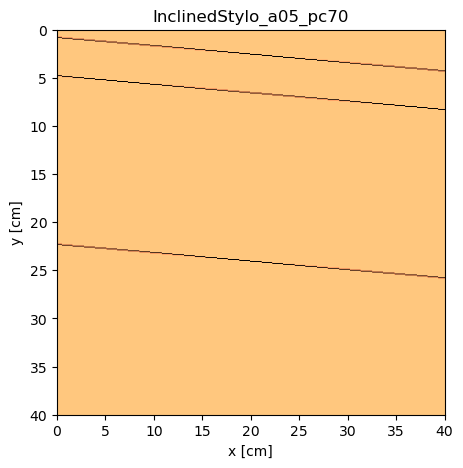

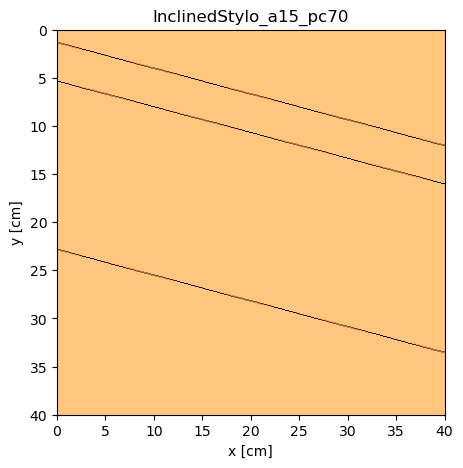

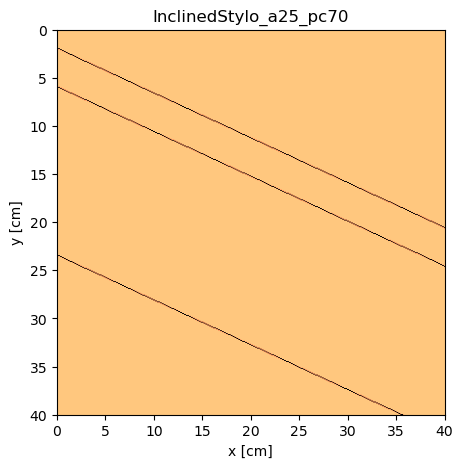

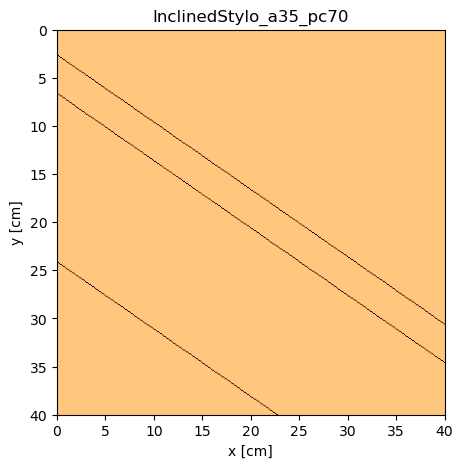

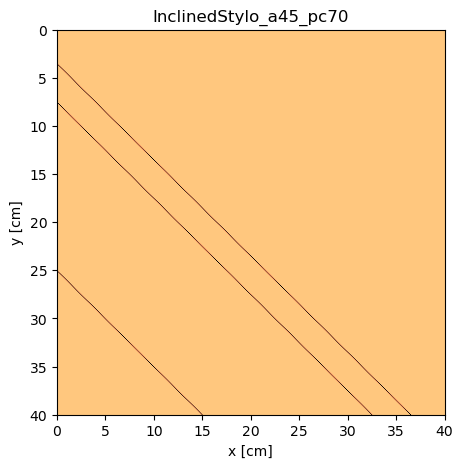

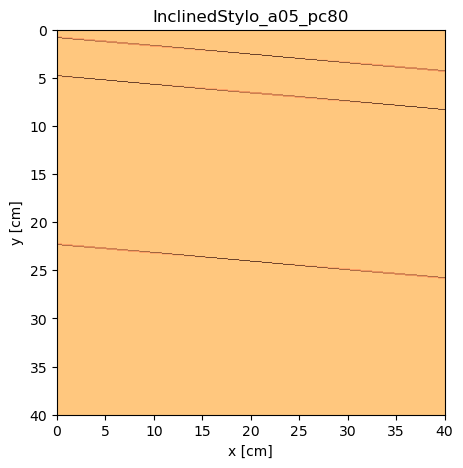

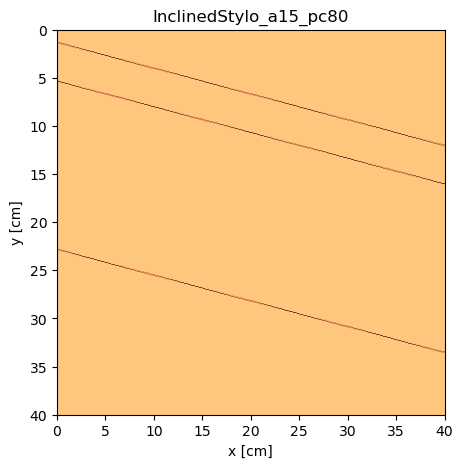

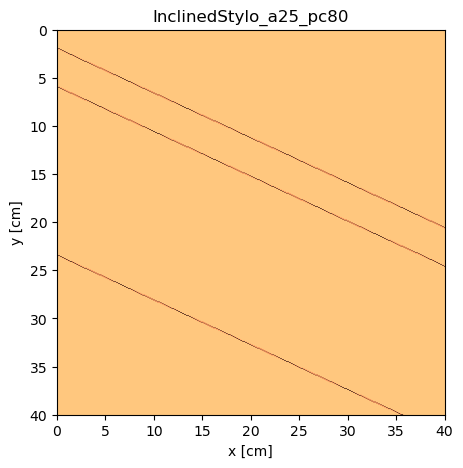

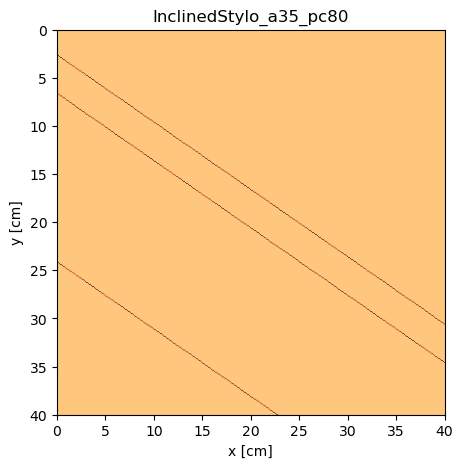

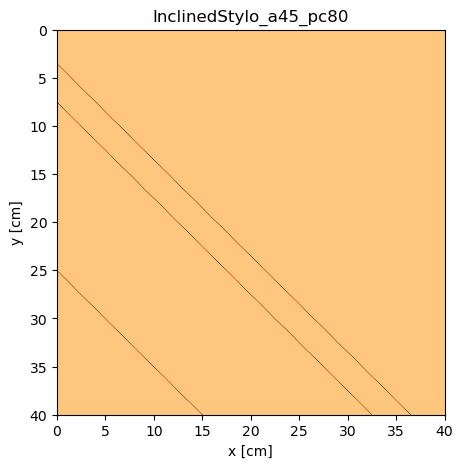

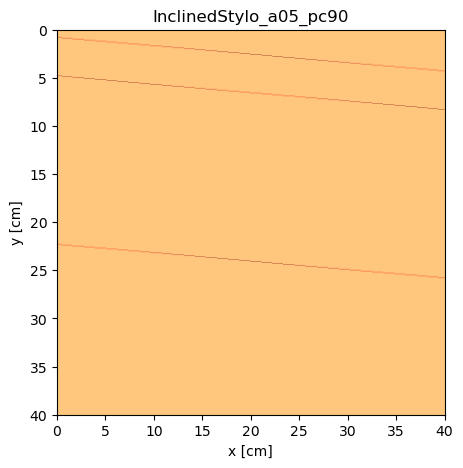

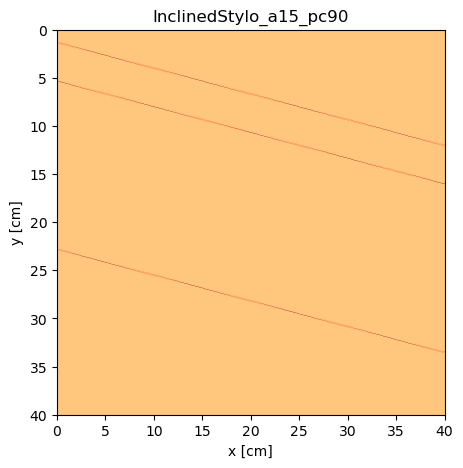

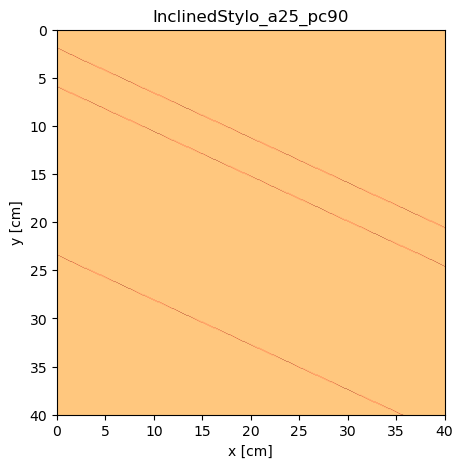

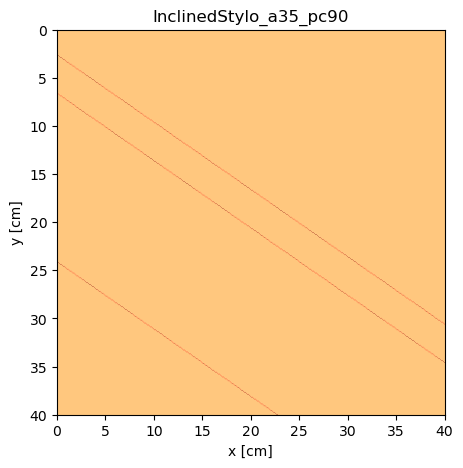

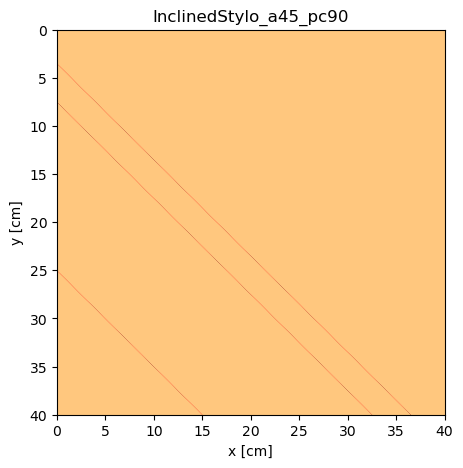

In [14]:
yo = [35, 75,250]
angles = [5,15,25,35, 45]


for pc in perc_changes:
    for angle in angles:
        vp_mod_sty,vs_mod_sty,rho_mod_sty= make_angled_stylolites(angle,
                                                                  vp_mod,
                                                                  vs_mod,
                                                                  rho_mod,
                                                                  pc, 
                                                                  yo=yo)
        
    
        # Write as binary
        expname = 'InclinedStylo_a%.2i_pc%.2i'%(angle,pc*100)
        vp_mod_sty.astype(np.float32).tofile(os.path.join(model_outpath,'%s.vp'%expname))#,format='<f')
        vs_mod_sty.astype(np.float32).tofile(os.path.join(model_outpath,'%s.vs'%expname))  #,format='<f')
        rho_mod_sty.astype(np.float32).tofile(os.path.join(model_outpath,'%s.rho'%expname))  #,format='<f')
        
        fig = plot_XYslice(vp_mod_sty, expname, abs_bounds)
        fig.savefig(os.path.join(figpath,expname+'.png'), format='png')

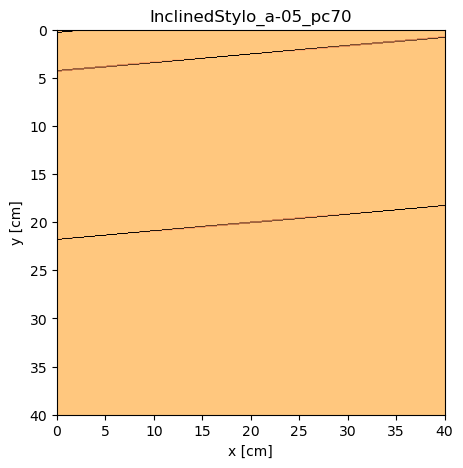

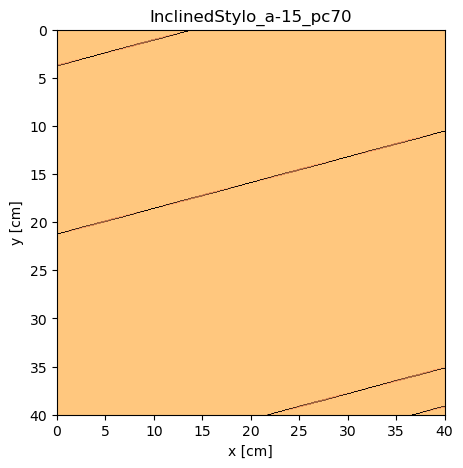

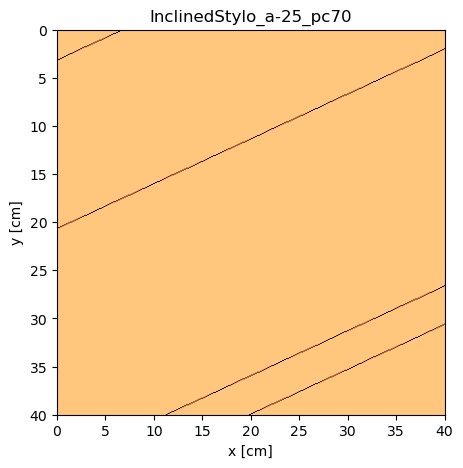

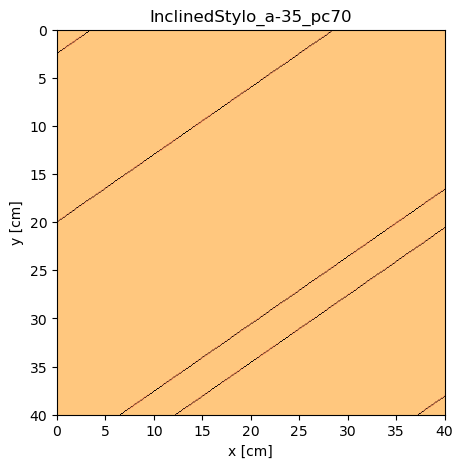

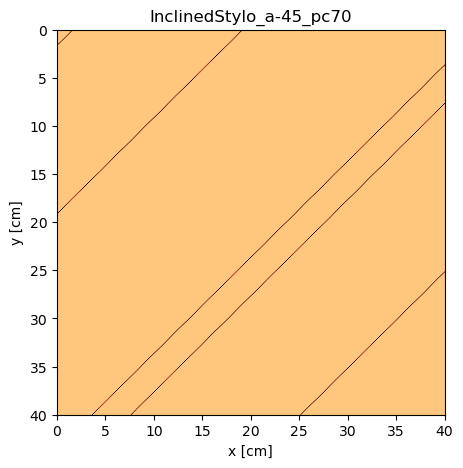

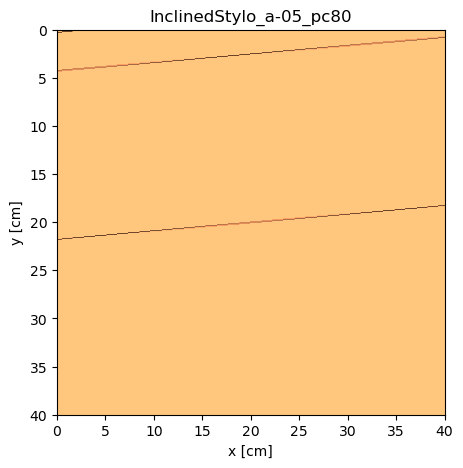

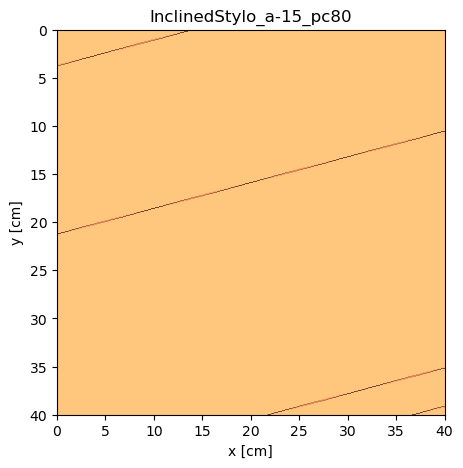

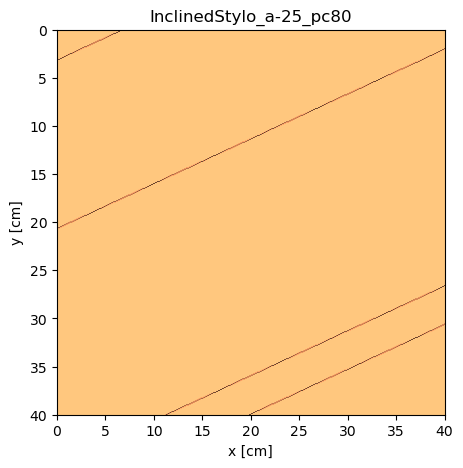

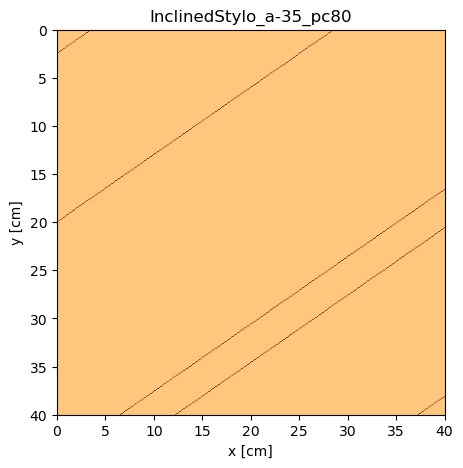

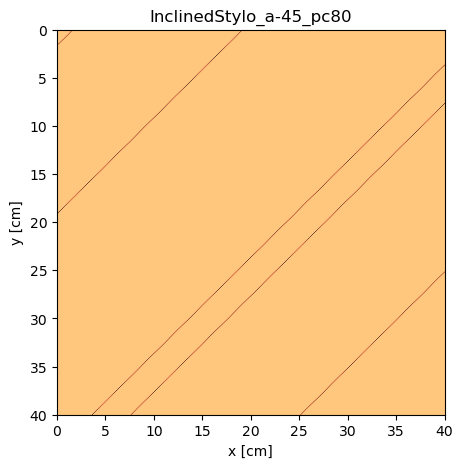

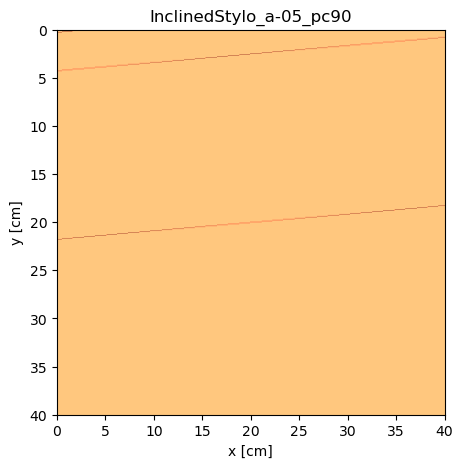

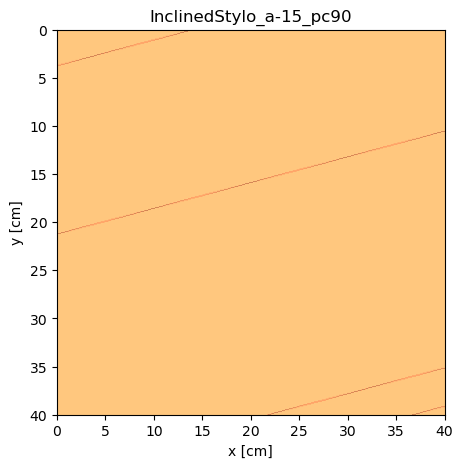

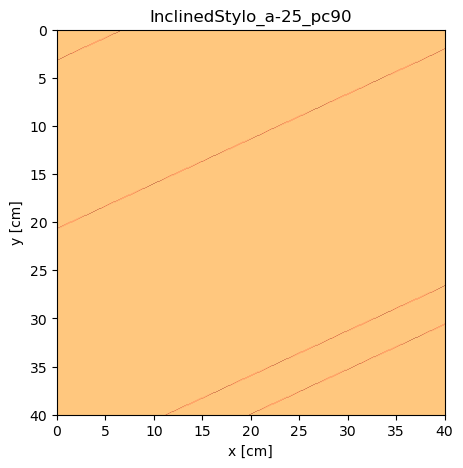

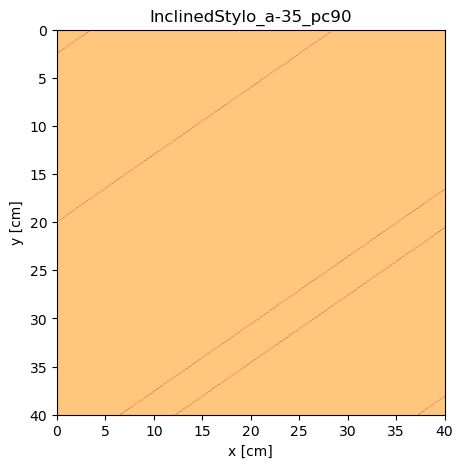

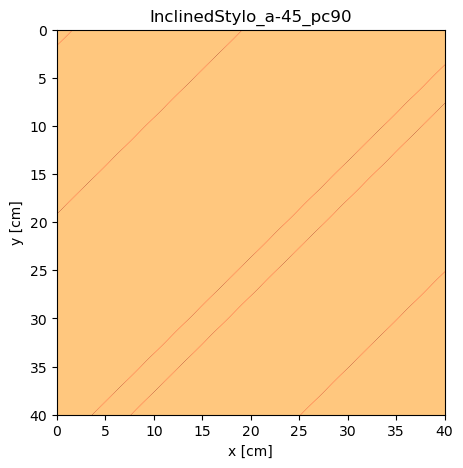

In [15]:
yo = [35, 75,250]
angles = [5,15,25,35, 45]


for pc in perc_changes:
    for angle in angles:
        vp_mod_sty,vs_mod_sty,rho_mod_sty= make_angled_stylolites(-1*angle,
                                                                  vp_mod,
                                                                  vs_mod,
                                                                  rho_mod,
                                                                  pc, 
                                                                  yo=yo)
        
    
        # Write as binary
        expname = 'InclinedStylo_a-%.2i_pc%.2i'%(angle,pc*100)
        vp_mod_sty.astype(np.float32).tofile(os.path.join(model_outpath,'%s.vp'%expname))#,format='<f')
        vs_mod_sty.astype(np.float32).tofile(os.path.join(model_outpath,'%s.vs'%expname))  #,format='<f')
        rho_mod_sty.astype(np.float32).tofile(os.path.join(model_outpath,'%s.rho'%expname))  #,format='<f')
        
        fig = plot_XYslice(vp_mod_sty, expname, abs_bounds)
        fig.savefig(os.path.join(figpath,expname+'.png'), format='png')

-----------------------------

# PINCHOUT

In [16]:
def make_pinchout_stylolites(sinewave,
                         vp_mod,
                         vs_mod,
                         rho_mod,
                         percchange, 
                         yo = [100, 175,350]):

    vp = np.mean(vp_mod)
    
    vp_mod_sty = vp_mod.copy()
    vs_mod_sty = vs_mod.copy()
    rho_mod_sty = rho_mod.copy()
    
    s0_thickness = np.linspace(5,0,nx).astype('int')
    s1_thickness = np.hstack([np.linspace(0,2,nx//2).astype('int'),np.linspace(2,0,nx//2).astype('int')])
    s2_thickness = np.linspace(-1,5,nx).astype('int')
    
    for ix in range(nx):
        sw_amp = np.round(sinewave[ix]).astype('int')
        # THREE STYLOLITES
        if s0_thickness[ix]>0:
            vp_mod_sty[ix,yo[0]+sw_amp:yo[0]+sw_amp+s0_thickness[ix],:] = vp*percchange
            vs_mod_sty[ix,yo[0]+sw_amp:yo[0]+sw_amp+s0_thickness[ix],:] = (vp*percchange)/1.61
            rho_mod_sty[ix,yo[0]+sw_amp:yo[0]+sw_amp+s0_thickness[ix],:] = 1000 * (0.31*(vp*percchange)**0.25)
        if s1_thickness[ix]>0:
            vp_mod_sty[ix,yo[1]+sw_amp:yo[1]+sw_amp+s1_thickness[ix],:] = vp*percchange
            vs_mod_sty[ix,yo[1]+sw_amp:yo[1]+sw_amp+s1_thickness[ix],:] = (vp*percchange)/1.61
            rho_mod_sty[ix,yo[1]+sw_amp:yo[1]+sw_amp+s1_thickness[ix],:] = 1000 * (0.31*(vp*percchange)**0.25)
        if s2_thickness[ix]>0:
            vp_mod_sty[ix,yo[2]+sw_amp:yo[2]+sw_amp+s2_thickness[ix],:] = vp*percchange
            vs_mod_sty[ix,yo[2]+sw_amp:yo[2]+sw_amp+s2_thickness[ix],:] = (vp*percchange)/1.61
            rho_mod_sty[ix,yo[2]+sw_amp:yo[2]+sw_amp+s2_thickness[ix],:] = 1000 * (0.31*(vp*percchange)**0.25)
        

    return vp_mod_sty,vs_mod_sty,rho_mod_sty

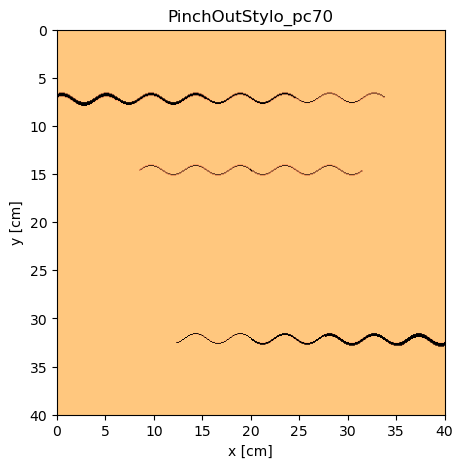

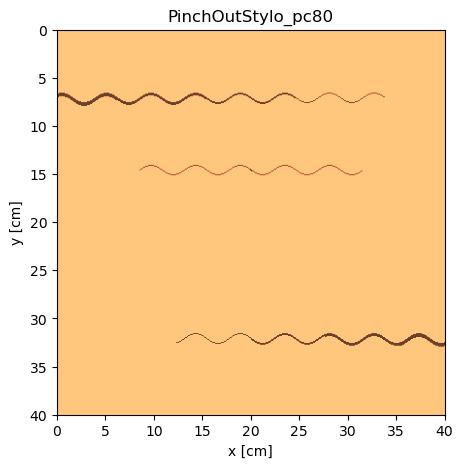

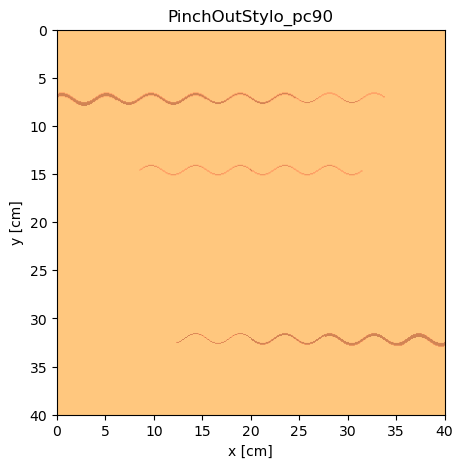

In [20]:
for pc in perc_changes:
    sinewave = unitwave * 5
    vp_mod_sty,vs_mod_sty,rho_mod_sty = make_pinchout_stylolites(sinewave,
                                                             vp_mod,
                                                             vs_mod,
                                                             rho_mod,
                                                             percchange=pc, 
                                                             yo = [100, 175,350])
    
    
    # Write as binary
    expname = 'PinchOutStylo_pc%.2i'%(pc*100)
    vp_mod_sty.astype(np.float32).tofile(os.path.join(model_outpath,'%s.vp'%expname))#,format='<f')
    vs_mod_sty.astype(np.float32).tofile(os.path.join(model_outpath,'%s.vs'%expname))  #,format='<f')
    rho_mod_sty.astype(np.float32).tofile(os.path.join(model_outpath,'%s.rho'%expname))  #,format='<f')
    
    fig = plot_XYslice(vp_mod_sty, expname, abs_bounds)
    fig.savefig(os.path.join(figpath,expname+'.png'), format='png')